In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.ESN_v4 import ESN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2022-12-21 17:47:59.892725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 17:47:59.892957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 17:47:59.934785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 17:47:59.935027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 17:47:59.935213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-12-21 17:47:59.936642: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 17:47:59.937115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 17:47:59.937318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 17:47:59.937500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_ESN'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'ESN_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')
    
    # whether to use AE data or just work on raw data
    use_ae_data = True # if false, specifying ae_idx will only show which dataset to use
    
    # autoencoder directory
    ae_idx = '046'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_026'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    use_ae_data = params_dict['use_ae_data']
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

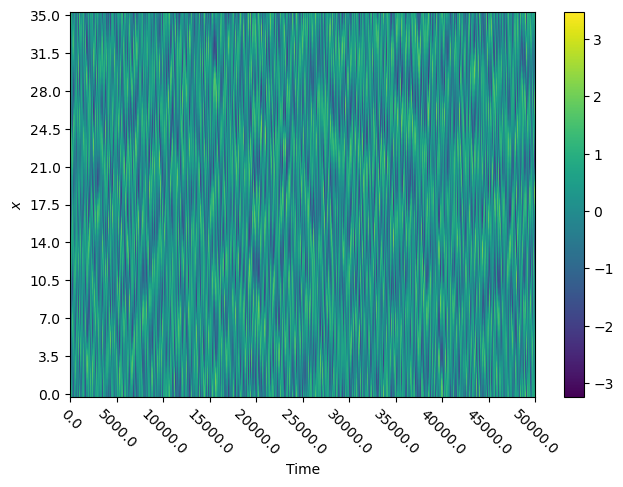

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# delaing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:numpoints_xgrid]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:numpoints_xgrid]

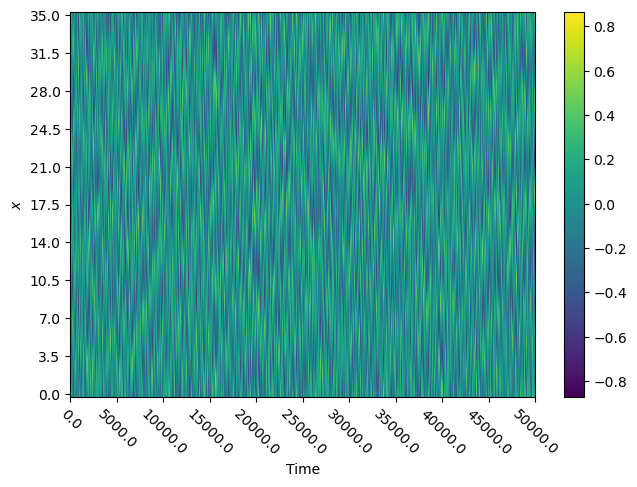

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [18]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [19]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

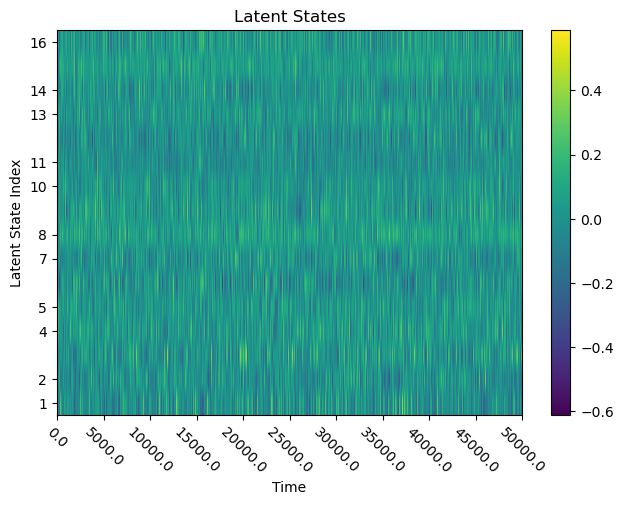

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# ESN

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    dt_rnn = 0.2
    num_input_tsteps = 375
    T_sample_input = num_input_tsteps*dt_rnn
    T_sample_output = T_sample_input
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    stddev_multiplier = 3
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'
    normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                                  # 'minmax' then stddev_multiplier has no effect
    ESN_layers_units = [500]
    stateful = True
    omega_in = [1.0]
    degree_of_connectivity = [10]
    rho_res = [0.5]
    usebias_Win = [False]
    alpha = [0.95]
    ESN_cell_activations = ['tanh']
    usebias_Wout = True
    
    activation_post_Wout = 'tanh'
    use_weights_post_dense = True
    
    # computing sparsity
    sparsity = [1-degree_of_connectivity[i]/(ESN_layers_units[i]-1) for i in range(len(ESN_layers_units))]
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr, # pointless, saved_data parameter
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset, # pointless, RNN parameter
        'stddev_multiplier':stddev_multiplier, # pointless, RNN parameter
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_input_tsteps':num_input_tsteps,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':ESN.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    patience = 10 # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 32
    fRMS = 0.5/100
    # zoneout_rate = 0.1
    # rnncell_dropout_rate = 0.01
    # denselayer_dropout_rate = 0.01
    

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        # 'zoneout_rate':zoneout_rate,
        # 'rnncell_dropout_rate':rnncell_dropout_rate,
        # 'denselayer_dropout_rate':denselayer_dropout_rate,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * (int( (1-test_split-val_split)*num_samples )//batch_size)
    num_val_arr[i] = batch_size * (int(val_split*num_samples)//batch_size)
    num_test_arr[i] = batch_size * int((num_samples - num_train_arr[i] - num_val_arr[i])//batch_size)
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]


    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [29]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (512, 375, 16)
 testing_data_rnn_input.shape :  (64, 375, 16)
     val_data_rnn_input.shape :  (64, 375, 16)


In [30]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states


    rnn_net = ESN(
        data_dim=data_dim,
        dt_rnn=dt_rnn,
        lambda_reg=lambda_reg,
        ESN_layers_units=ESN_layers_units,
        stddev=stddev,
        noise_type=noise_type,
        stateful=stateful,
        omega_in=omega_in,
        sparsity=sparsity,
        rho_res=rho_res,
        usebias_Win=usebias_Win,
        alpha=alpha,
        ESN_cell_activations=ESN_cell_activations,
        prng_seed=prng_seed,
        usebias_Wout=usebias_Wout,
        use_weights_post_dense=use_weights_post_dense,
        activation_post_Wout=activation_post_Wout,
        batch_size=batch_size,
    )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.build(input_shape=(1,) + training_data_rnn_input.shape[1:])
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    
    rnn_net = ESN(
        load_file=load_file,
    )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_ESN_weights.hdf5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.33066237
stddev : 0.001653311848640442


In [31]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [32]:
training_data_rnn_input.dtype

dtype('float32')

In [33]:
lambda_reg = float(lambda_reg)

In [34]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [35]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    metrics=['mse', NMSE(divisor_arr=time_stddev)],
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1,
            shuffle=not stateful,
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
16/16 [==============================] - ETA: 0s - loss: 0.1194 - mse: 0.1193 - NMSE: 1.0739 - tot_time: 0h 0m 4.4s

Epoch 1: val_NMSE improved from inf to 0.66730, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 4s 199ms/step - loss: 0.1194 - mse: 0.1193 - NMSE: 1.0739 - val_loss: 0.0742 - val_mse: 0.0741 - val_NMSE: 0.6673
Epoch 2/1000
16/16 [==============================] - ETA: 0s - loss: 0.0523 - mse: 0.0522 - NMSE: 0.4698 - tot_time: 0h 0m 7.4s

Epoch 2: val_NMSE improved from 0.66730 to 0.31425, saving model to

Epoch 15/1000
16/16 [==============================] - ETA: 0s - loss: 0.0018 - mse: 0.0017 - NMSE: 0.0151 - tot_time: 0h 0m 46.5s

Epoch 15: val_NMSE improved from 0.01689 to 0.01621, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 188ms/step - loss: 0.0018 - mse: 0.0017 - NMSE: 0.0151 - val_loss: 0.0019 - val_mse: 0.0018 - val_NMSE: 0.0162
Epoch 16/1000
16/16 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0016 - NMSE: 0.0145 - tot_time: 0h 0m 49.4s

Epoch 16: val_NMSE improved from 0.01621 to 0.01563, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==========================

Epoch 30/1000
16/16 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0102 - tot_time: 0h 1m 32.2s

Epoch 30: val_NMSE improved from 0.01157 to 0.01136, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 191ms/step - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0102 - val_loss: 0.0013 - val_mse: 0.0013 - val_NMSE: 0.0114
Epoch 31/1000
16/16 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0100 - tot_time: 0h 1m 35.2s

Epoch 31: val_NMSE improved from 0.01136 to 0.01116, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==========================

Epoch 45/1000
16/16 [==============================] - ETA: 0s - loss: 9.7340e-04 - mse: 8.8352e-04 - NMSE: 0.0080 - tot_time: 0h 2m 17.6s

Epoch 45: val_NMSE improved from 0.00912 to 0.00899, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 193ms/step - loss: 9.7340e-04 - mse: 8.8352e-04 - NMSE: 0.0080 - val_loss: 0.0011 - val_mse: 9.9889e-04 - val_NMSE: 0.0090
Epoch 46/1000
16/16 [==============================] - ETA: 0s - loss: 9.6058e-04 - mse: 8.7050e-04 - NMSE: 0.0078 - tot_time: 0h 2m 20.6s

Epoch 46: val_NMSE improved from 0.00899 to 0.00887, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16

16/16 [==============================] - ETA: 0s - loss: 8.2114e-04 - mse: 7.2843e-04 - NMSE: 0.0066 - tot_time: 0h 2m 59.7s

Epoch 59: val_NMSE improved from 0.00759 to 0.00750, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 184ms/step - loss: 8.2114e-04 - mse: 7.2843e-04 - NMSE: 0.0066 - val_loss: 9.2562e-04 - val_mse: 8.3281e-04 - val_NMSE: 0.0075
Epoch 60/1000
16/16 [==============================] - ETA: 0s - loss: 8.1214e-04 - mse: 7.1924e-04 - NMSE: 0.0065 - tot_time: 0h 3m 2.7s

Epoch 60: val_NMSE improved from 0.00750 to 0.00741, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [=========

16/16 [==============================] - ETA: 0s - loss: 7.1122e-04 - mse: 6.1614e-04 - NMSE: 0.0055 - tot_time: 0h 3m 42.2s

Epoch 73: val_NMSE improved from 0.00647 to 0.00640, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 188ms/step - loss: 7.1122e-04 - mse: 6.1614e-04 - NMSE: 0.0055 - val_loss: 8.0596e-04 - val_mse: 7.1081e-04 - val_NMSE: 0.0064
Epoch 74/1000
16/16 [==============================] - ETA: 0s - loss: 7.0451e-04 - mse: 6.0929e-04 - NMSE: 0.0055 - tot_time: 0h 3m 45.1s

Epoch 74: val_NMSE improved from 0.00640 to 0.00633, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [========

16/16 [==============================] - ETA: 0s - loss: 6.2793e-04 - mse: 5.3121e-04 - NMSE: 0.0048 - tot_time: 0h 4m 24.7s

Epoch 87: val_NMSE improved from 0.00561 to 0.00556, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 193ms/step - loss: 6.2793e-04 - mse: 5.3121e-04 - NMSE: 0.0048 - val_loss: 7.1437e-04 - val_mse: 6.1760e-04 - val_NMSE: 0.0056
Epoch 88/1000
16/16 [==============================] - ETA: 0s - loss: 6.2280e-04 - mse: 5.2599e-04 - NMSE: 0.0047 - tot_time: 0h 4m 27.9s

Epoch 88: val_NMSE improved from 0.00556 to 0.00551, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [========

16/16 [==============================] - ETA: 0s - loss: 5.6250e-04 - mse: 4.6487e-04 - NMSE: 0.0042 - tot_time: 0h 5m 7.3s

Epoch 101: val_NMSE improved from 0.00494 to 0.00490, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 204ms/step - loss: 5.6250e-04 - mse: 4.6487e-04 - NMSE: 0.0042 - val_loss: 6.4210e-04 - val_mse: 5.4445e-04 - val_NMSE: 0.0049
Epoch 102/1000
16/16 [==============================] - ETA: 0s - loss: 5.5832e-04 - mse: 4.6065e-04 - NMSE: 0.0041 - tot_time: 0h 5m 10.5s

Epoch 102: val_NMSE improved from 0.00490 to 0.00486, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [======

Epoch 115/1000
16/16 [==============================] - ETA: 0s - loss: 5.0968e-04 - mse: 4.1173e-04 - NMSE: 0.0037 - tot_time: 0h 5m 49.0s

Epoch 115: val_NMSE improved from 0.00440 to 0.00436, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 181ms/step - loss: 5.0968e-04 - mse: 4.1173e-04 - NMSE: 0.0037 - val_loss: 5.8270e-04 - val_mse: 4.8474e-04 - val_NMSE: 0.0044
Epoch 116/1000
16/16 [==============================] - ETA: 0s - loss: 5.0632e-04 - mse: 4.0835e-04 - NMSE: 0.0037 - tot_time: 0h 5m 51.9s

Epoch 116: val_NMSE improved from 0.00436 to 0.00433, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoi

Epoch 129/1000
16/16 [==============================] - ETA: 0s - loss: 4.6602e-04 - mse: 3.6815e-04 - NMSE: 0.0033 - tot_time: 0h 6m 30.6s

Epoch 129: val_NMSE improved from 0.00394 to 0.00391, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 194ms/step - loss: 4.6602e-04 - mse: 3.6815e-04 - NMSE: 0.0033 - val_loss: 5.3263e-04 - val_mse: 4.3476e-04 - val_NMSE: 0.0039
Epoch 130/1000
16/16 [==============================] - ETA: 0s - loss: 4.6319e-04 - mse: 3.6533e-04 - NMSE: 0.0033 - tot_time: 0h 6m 33.5s

Epoch 130: val_NMSE improved from 0.00391 to 0.00388, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoi

Epoch 143/1000
16/16 [==============================] - ETA: 0s - loss: 4.2839e-04 - mse: 3.3082e-04 - NMSE: 0.0030 - tot_time: 0h 7m 12.5s

Epoch 143: val_NMSE improved from 0.00357 to 0.00354, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 186ms/step - loss: 4.2839e-04 - mse: 3.3082e-04 - NMSE: 0.0030 - val_loss: 4.9082e-04 - val_mse: 3.9327e-04 - val_NMSE: 0.0035
Epoch 144/1000
16/16 [==============================] - ETA: 0s - loss: 4.2585e-04 - mse: 3.2831e-04 - NMSE: 0.0030 - tot_time: 0h 7m 15.5s

Epoch 144: val_NMSE improved from 0.00354 to 0.00352, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoi

Epoch 157/1000
16/16 [==============================] - ETA: 0s - loss: 3.9551e-04 - mse: 2.9838e-04 - NMSE: 0.0027 - tot_time: 0h 7m 54.5s

Epoch 157: val_NMSE improved from 0.00324 to 0.00322, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 193ms/step - loss: 3.9551e-04 - mse: 2.9838e-04 - NMSE: 0.0027 - val_loss: 4.5444e-04 - val_mse: 3.5733e-04 - val_NMSE: 0.0032
Epoch 158/1000
16/16 [==============================] - ETA: 0s - loss: 3.9336e-04 - mse: 2.9626e-04 - NMSE: 0.0027 - tot_time: 0h 7m 57.4s

Epoch 158: val_NMSE improved from 0.00322 to 0.00320, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoi

Epoch 171/1000
16/16 [==============================] - ETA: 0s - loss: 3.6686e-04 - mse: 2.7021e-04 - NMSE: 0.0024 - tot_time: 0h 8m 37.1s

Epoch 171: val_NMSE improved from 0.00295 to 0.00293, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 189ms/step - loss: 3.6686e-04 - mse: 2.7021e-04 - NMSE: 0.0024 - val_loss: 4.2227e-04 - val_mse: 3.2564e-04 - val_NMSE: 0.0029
Epoch 172/1000
16/16 [==============================] - ETA: 0s - loss: 3.6496e-04 - mse: 2.6834e-04 - NMSE: 0.0024 - tot_time: 0h 8m 40.1s

Epoch 172: val_NMSE improved from 0.00293 to 0.00291, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoi

Epoch 185/1000
16/16 [==============================] - ETA: 0s - loss: 3.4137e-04 - mse: 2.4519e-04 - NMSE: 0.0022 - tot_time: 0h 9m 19.4s

Epoch 185: val_NMSE improved from 0.00269 to 0.00267, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 192ms/step - loss: 3.4137e-04 - mse: 2.4519e-04 - NMSE: 0.0022 - val_loss: 3.9321e-04 - val_mse: 2.9705e-04 - val_NMSE: 0.0027
Epoch 186/1000
16/16 [==============================] - ETA: 0s - loss: 3.3967e-04 - mse: 2.4352e-04 - NMSE: 0.0022 - tot_time: 0h 9m 22.5s

Epoch 186: val_NMSE improved from 0.00267 to 0.00266, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoi

Epoch 199/1000
16/16 [==============================] - ETA: 0s - loss: 3.1864e-04 - mse: 2.2287e-04 - NMSE: 0.0020 - tot_time: 0h 10m 1.7s

Epoch 199: val_NMSE improved from 0.00245 to 0.00244, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 201ms/step - loss: 3.1864e-04 - mse: 2.2287e-04 - NMSE: 0.0020 - val_loss: 3.6651e-04 - val_mse: 2.7076e-04 - val_NMSE: 0.0024
Epoch 200/1000
16/16 [==============================] - ETA: 0s - loss: 3.1709e-04 - mse: 2.2135e-04 - NMSE: 0.0020 - tot_time: 0h 10m 4.7s

Epoch 200: val_NMSE improved from 0.00244 to 0.00242, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoi

Epoch 213/1000
16/16 [==============================] - ETA: 0s - loss: 2.9830e-04 - mse: 2.0286e-04 - NMSE: 0.0018 - tot_time: 0h 10m 44.4s

Epoch 213: val_NMSE improved from 0.00224 to 0.00223, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 197ms/step - loss: 2.9830e-04 - mse: 2.0286e-04 - NMSE: 0.0018 - val_loss: 3.4339e-04 - val_mse: 2.4796e-04 - val_NMSE: 0.0022
Epoch 214/1000
16/16 [==============================] - ETA: 0s - loss: 2.9704e-04 - mse: 2.0162e-04 - NMSE: 0.0018 - tot_time: 0h 10m 47.4s

Epoch 214: val_NMSE improved from 0.00223 to 0.00222, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckp

Epoch 227/1000
16/16 [==============================] - ETA: 0s - loss: 2.8035e-04 - mse: 1.8513e-04 - NMSE: 0.0017 - tot_time: 0h 11m 26.9s

Epoch 227: val_NMSE improved from 0.00206 to 0.00205, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 187ms/step - loss: 2.8035e-04 - mse: 1.8513e-04 - NMSE: 0.0017 - val_loss: 3.2252e-04 - val_mse: 2.2731e-04 - val_NMSE: 0.0020
Epoch 228/1000
16/16 [==============================] - ETA: 0s - loss: 2.7913e-04 - mse: 1.8393e-04 - NMSE: 0.0017 - tot_time: 0h 11m 29.9s

Epoch 228: val_NMSE improved from 0.00205 to 0.00203, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckp

Epoch 241/1000
16/16 [==============================] - ETA: 0s - loss: 2.6424e-04 - mse: 1.6914e-04 - NMSE: 0.0015 - tot_time: 0h 12m 8.1s

Epoch 241: val_NMSE improved from 0.00189 to 0.00188, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 187ms/step - loss: 2.6424e-04 - mse: 1.6914e-04 - NMSE: 0.0015 - val_loss: 3.0369e-04 - val_mse: 2.0860e-04 - val_NMSE: 0.0019
Epoch 242/1000
16/16 [==============================] - ETA: 0s - loss: 2.6315e-04 - mse: 1.6805e-04 - NMSE: 0.0015 - tot_time: 0h 12m 10.9s

Epoch 242: val_NMSE improved from 0.00188 to 0.00187, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpo

Epoch 255/1000
16/16 [==============================] - ETA: 0s - loss: 2.4983e-04 - mse: 1.5476e-04 - NMSE: 0.0014 - tot_time: 0h 12m 49.4s

Epoch 255: val_NMSE improved from 0.00174 to 0.00173, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 182ms/step - loss: 2.4983e-04 - mse: 1.5476e-04 - NMSE: 0.0014 - val_loss: 2.8704e-04 - val_mse: 1.9197e-04 - val_NMSE: 0.0017
Epoch 256/1000
16/16 [==============================] - ETA: 0s - loss: 2.4885e-04 - mse: 1.5378e-04 - NMSE: 0.0014 - tot_time: 0h 12m 52.3s

Epoch 256: val_NMSE improved from 0.00173 to 0.00172, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckp

Epoch 269/1000
16/16 [==============================] - ETA: 0s - loss: 2.3691e-04 - mse: 1.4179e-04 - NMSE: 0.0013 - tot_time: 0h 13m 30.3s

Epoch 269: val_NMSE improved from 0.00160 to 0.00159, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 181ms/step - loss: 2.3691e-04 - mse: 1.4179e-04 - NMSE: 0.0013 - val_loss: 2.7225e-04 - val_mse: 1.7712e-04 - val_NMSE: 0.0016
Epoch 270/1000
16/16 [==============================] - ETA: 0s - loss: 2.3597e-04 - mse: 1.4083e-04 - NMSE: 0.0013 - tot_time: 0h 13m 33.2s

Epoch 270: val_NMSE improved from 0.00159 to 0.00158, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckp

Epoch 283/1000
16/16 [==============================] - ETA: 0s - loss: 2.2533e-04 - mse: 1.3009e-04 - NMSE: 0.0012 - tot_time: 0h 14m 11.6s

Epoch 283: val_NMSE improved from 0.00148 to 0.00147, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 183ms/step - loss: 2.2533e-04 - mse: 1.3009e-04 - NMSE: 0.0012 - val_loss: 2.5891e-04 - val_mse: 1.6366e-04 - val_NMSE: 0.0015
Epoch 284/1000
16/16 [==============================] - ETA: 0s - loss: 2.2459e-04 - mse: 1.2933e-04 - NMSE: 0.0012 - tot_time: 0h 14m 14.5s

Epoch 284: val_NMSE improved from 0.00147 to 0.00146, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckp

Epoch 297/1000
16/16 [==============================] - ETA: 0s - loss: 2.1518e-04 - mse: 1.1976e-04 - NMSE: 0.0011 - tot_time: 0h 14m 52.7s

Epoch 297: val_NMSE improved from 0.00137 to 0.00136, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 186ms/step - loss: 2.1518e-04 - mse: 1.1976e-04 - NMSE: 0.0011 - val_loss: 2.4701e-04 - val_mse: 1.5159e-04 - val_NMSE: 0.0014
Epoch 298/1000
16/16 [==============================] - ETA: 0s - loss: 2.1442e-04 - mse: 1.1899e-04 - NMSE: 0.0011 - tot_time: 0h 14m 55.7s

Epoch 298: val_NMSE improved from 0.00136 to 0.00136, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckp

Epoch 311/1000
16/16 [==============================] - ETA: 0s - loss: 2.0616e-04 - mse: 1.1054e-04 - NMSE: 9.9504e-04 - tot_time: 0h 15m 34.2s

Epoch 311: val_NMSE improved from 0.00127 to 0.00127, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 186ms/step - loss: 2.0616e-04 - mse: 1.1054e-04 - NMSE: 9.9504e-04 - val_loss: 2.3633e-04 - val_mse: 1.4071e-04 - val_NMSE: 0.0013
Epoch 312/1000
16/16 [==============================] - ETA: 0s - loss: 2.0556e-04 - mse: 1.0993e-04 - NMSE: 9.8948e-04 - tot_time: 0h 15m 37.1s

Epoch 312: val_NMSE improved from 0.00127 to 0.00126, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHis

Epoch 325/1000
16/16 [==============================] - ETA: 0s - loss: 1.9849e-04 - mse: 1.0266e-04 - NMSE: 9.2410e-04 - tot_time: 0h 16m 15.4s

Epoch 325: val_NMSE improved from 0.00119 to 0.00118, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 182ms/step - loss: 1.9849e-04 - mse: 1.0266e-04 - NMSE: 9.2410e-04 - val_loss: 2.2689e-04 - val_mse: 1.3106e-04 - val_NMSE: 0.0012
Epoch 326/1000
16/16 [==============================] - ETA: 0s - loss: 1.9801e-04 - mse: 1.0217e-04 - NMSE: 9.1970e-04 - tot_time: 0h 16m 18.4s

Epoch 326: val_NMSE improved from 0.00118 to 0.00117, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHis

Epoch 339/1000
16/16 [==============================] - ETA: 0s - loss: 1.9169e-04 - mse: 9.5658e-05 - NMSE: 8.6106e-04 - tot_time: 0h 16m 56.8s

Epoch 339: val_NMSE improved from 0.00111 to 0.00111, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 187ms/step - loss: 1.9169e-04 - mse: 9.5658e-05 - NMSE: 8.6106e-04 - val_loss: 2.1907e-04 - val_mse: 1.2302e-04 - val_NMSE: 0.0011
Epoch 340/1000
16/16 [==============================] - ETA: 0s - loss: 1.9123e-04 - mse: 9.5183e-05 - NMSE: 8.5678e-04 - tot_time: 0h 16m 59.8s

Epoch 340: val_NMSE improved from 0.00111 to 0.00110, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHis

Epoch 353/1000
16/16 [==============================] - ETA: 0s - loss: 1.8561e-04 - mse: 8.9371e-05 - NMSE: 8.0446e-04 - tot_time: 0h 17m 37.9s

Epoch 353: val_NMSE improved from 0.00105 to 0.00105, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 180ms/step - loss: 1.8561e-04 - mse: 8.9371e-05 - NMSE: 8.0446e-04 - val_loss: 2.1244e-04 - val_mse: 1.1619e-04 - val_NMSE: 0.0010
Epoch 354/1000
16/16 [==============================] - ETA: 0s - loss: 1.8522e-04 - mse: 8.8962e-05 - NMSE: 8.0079e-04 - tot_time: 0h 17m 41.0s

Epoch 354: val_NMSE improved from 0.00105 to 0.00104, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHis

Epoch 367/1000
16/16 [==============================] - ETA: 0s - loss: 1.8025e-04 - mse: 8.3828e-05 - NMSE: 7.5457e-04 - tot_time: 0h 18m 19.2s

Epoch 367: val_NMSE improved from 0.00099 to 0.00099, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 183ms/step - loss: 1.8025e-04 - mse: 8.3828e-05 - NMSE: 7.5457e-04 - val_loss: 2.0637e-04 - val_mse: 1.0993e-04 - val_NMSE: 9.8953e-04
Epoch 368/1000
16/16 [==============================] - ETA: 0s - loss: 1.7991e-04 - mse: 8.3467e-05 - NMSE: 7.5132e-04 - tot_time: 0h 18m 22.2s

Epoch 368: val_NMSE improved from 0.00099 to 0.00099, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/Los

Epoch 381/1000
16/16 [==============================] - ETA: 0s - loss: 1.7541e-04 - mse: 7.8813e-05 - NMSE: 7.0943e-04 - tot_time: 0h 19m 0.4s

Epoch 381: val_NMSE improved from 0.00095 to 0.00094, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 194ms/step - loss: 1.7541e-04 - mse: 7.8813e-05 - NMSE: 7.0943e-04 - val_loss: 2.0128e-04 - val_mse: 1.0468e-04 - val_NMSE: 9.4223e-04
Epoch 382/1000
16/16 [==============================] - ETA: 0s - loss: 1.7513e-04 - mse: 7.8527e-05 - NMSE: 7.0685e-04 - tot_time: 0h 19m 3.2s

Epoch 382: val_NMSE improved from 0.00094 to 0.00094, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossH

Epoch 395/1000
16/16 [==============================] - ETA: 0s - loss: 1.7121e-04 - mse: 7.4469e-05 - NMSE: 6.7033e-04 - tot_time: 0h 19m 41.4s

Epoch 395: val_NMSE improved from 0.00090 to 0.00090, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 184ms/step - loss: 1.7121e-04 - mse: 7.4469e-05 - NMSE: 6.7033e-04 - val_loss: 1.9658e-04 - val_mse: 9.9835e-05 - val_NMSE: 8.9865e-04
Epoch 396/1000
16/16 [==============================] - ETA: 0s - loss: 1.7089e-04 - mse: 7.4140e-05 - NMSE: 6.6737e-04 - tot_time: 0h 19m 44.3s

Epoch 396: val_NMSE improved from 0.00090 to 0.00090, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/Los

Epoch 409/1000
16/16 [==============================] - ETA: 0s - loss: 1.6752e-04 - mse: 7.0647e-05 - NMSE: 6.3593e-04 - tot_time: 0h 20m 22.6s

Epoch 409: val_NMSE improved from 0.00086 to 0.00086, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 188ms/step - loss: 1.6752e-04 - mse: 7.0647e-05 - NMSE: 6.3593e-04 - val_loss: 1.9250e-04 - val_mse: 9.5625e-05 - val_NMSE: 8.6076e-04
Epoch 410/1000
16/16 [==============================] - ETA: 0s - loss: 1.6732e-04 - mse: 7.0440e-05 - NMSE: 6.3406e-04 - tot_time: 0h 20m 25.5s

Epoch 410: val_NMSE improved from 0.00086 to 0.00086, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/Los

Epoch 423/1000
16/16 [==============================] - ETA: 0s - loss: 1.6444e-04 - mse: 6.7469e-05 - NMSE: 6.0732e-04 - tot_time: 0h 21m 3.5s

Epoch 423: val_NMSE improved from 0.00083 to 0.00083, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 183ms/step - loss: 1.6444e-04 - mse: 6.7469e-05 - NMSE: 6.0732e-04 - val_loss: 1.8902e-04 - val_mse: 9.2046e-05 - val_NMSE: 8.2855e-04
Epoch 424/1000
16/16 [==============================] - ETA: 0s - loss: 1.6417e-04 - mse: 6.7192e-05 - NMSE: 6.0483e-04 - tot_time: 0h 21m 6.4s

Epoch 424: val_NMSE improved from 0.00083 to 0.00083, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossH

Epoch 437/1000
16/16 [==============================] - ETA: 0s - loss: 1.6162e-04 - mse: 6.4571e-05 - NMSE: 5.8123e-04 - tot_time: 0h 21m 44.8s

Epoch 437: val_NMSE improved from 0.00080 to 0.00080, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 181ms/step - loss: 1.6162e-04 - mse: 6.4571e-05 - NMSE: 5.8123e-04 - val_loss: 1.8590e-04 - val_mse: 8.8844e-05 - val_NMSE: 7.9973e-04
Epoch 438/1000
16/16 [==============================] - ETA: 0s - loss: 1.6155e-04 - mse: 6.4496e-05 - NMSE: 5.8055e-04 - tot_time: 0h 21m 47.6s

Epoch 438: val_NMSE improved from 0.00080 to 0.00080, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/Los

Epoch 451/1000
16/16 [==============================] - ETA: 0s - loss: 1.5939e-04 - mse: 6.2292e-05 - NMSE: 5.6072e-04 - tot_time: 0h 22m 25.6s

Epoch 451: val_NMSE improved from 0.00078 to 0.00077, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 187ms/step - loss: 1.5939e-04 - mse: 6.2292e-05 - NMSE: 5.6072e-04 - val_loss: 1.8316e-04 - val_mse: 8.6059e-05 - val_NMSE: 7.7466e-04
Epoch 452/1000
16/16 [==============================] - ETA: 0s - loss: 1.5924e-04 - mse: 6.2142e-05 - NMSE: 5.5937e-04 - tot_time: 0h 22m 28.6s

Epoch 452: val_NMSE improved from 0.00077 to 0.00077, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/Los

Epoch 465/1000
16/16 [==============================] - ETA: 0s - loss: 1.5751e-04 - mse: 6.0386e-05 - NMSE: 5.4356e-04 - tot_time: 0h 23m 6.7s

Epoch 465: val_NMSE improved from 0.00076 to 0.00075, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 182ms/step - loss: 1.5751e-04 - mse: 6.0386e-05 - NMSE: 5.4356e-04 - val_loss: 1.8096e-04 - val_mse: 8.3830e-05 - val_NMSE: 7.5459e-04
Epoch 466/1000
16/16 [==============================] - ETA: 0s - loss: 1.5736e-04 - mse: 6.0238e-05 - NMSE: 5.4223e-04 - tot_time: 0h 23m 9.7s

Epoch 466: val_NMSE improved from 0.00075 to 0.00075, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossH

Epoch 479/1000
16/16 [==============================] - ETA: 0s - loss: 1.5563e-04 - mse: 5.8499e-05 - NMSE: 5.2658e-04 - tot_time: 0h 23m 48.2s

Epoch 479: val_NMSE improved from 0.00074 to 0.00073, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 185ms/step - loss: 1.5563e-04 - mse: 5.8499e-05 - NMSE: 5.2658e-04 - val_loss: 1.7861e-04 - val_mse: 8.1480e-05 - val_NMSE: 7.3344e-04
Epoch 480/1000
16/16 [==============================] - ETA: 0s - loss: 1.5543e-04 - mse: 5.8306e-05 - NMSE: 5.2483e-04 - tot_time: 0h 23m 51.0s

Epoch 480: val_NMSE improved from 0.00073 to 0.00073, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/Los

Epoch 493/1000
16/16 [==============================] - ETA: 0s - loss: 1.5405e-04 - mse: 5.6938e-05 - NMSE: 5.1252e-04 - tot_time: 0h 24m 28.9s

Epoch 493: val_NMSE improved from 0.00072 to 0.00072, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 184ms/step - loss: 1.5405e-04 - mse: 5.6938e-05 - NMSE: 5.1252e-04 - val_loss: 1.7674e-04 - val_mse: 7.9626e-05 - val_NMSE: 7.1675e-04
Epoch 494/1000
16/16 [==============================] - ETA: 0s - loss: 1.5396e-04 - mse: 5.6844e-05 - NMSE: 5.1168e-04 - tot_time: 0h 24m 31.9s

Epoch 494: val_NMSE improved from 0.00072 to 0.00072, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/Los

16/16 [==============================] - ETA: 0s - loss: 1.5261e-04 - mse: 5.5521e-05 - NMSE: 4.9976e-04 - tot_time: 0h 25m 10.1s

Epoch 507: val_NMSE improved from 0.00070 to 0.00070, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 192ms/step - loss: 1.5261e-04 - mse: 5.5521e-05 - NMSE: 4.9976e-04 - val_loss: 1.7500e-04 - val_mse: 7.7913e-05 - val_NMSE: 7.0132e-04
Epoch 508/1000
16/16 [==============================] - ETA: 0s - loss: 1.5260e-04 - mse: 5.5513e-05 - NMSE: 4.9970e-04 - tot_time: 0h 25m 13.1s

Epoch 508: val_NMSE improved from 0.00070 to 0.00070, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheck

16/16 [==============================] - ETA: 0s - loss: 1.5139e-04 - mse: 5.4347e-05 - NMSE: 4.8920e-04 - tot_time: 0h 25m 50.9s

Epoch 521: val_NMSE improved from 0.00069 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 181ms/step - loss: 1.5139e-04 - mse: 5.4347e-05 - NMSE: 4.8920e-04 - val_loss: 1.7336e-04 - val_mse: 7.6313e-05 - val_NMSE: 6.8693e-04
Epoch 522/1000
16/16 [==============================] - ETA: 0s - loss: 1.5133e-04 - mse: 5.4284e-05 - NMSE: 4.8864e-04 - tot_time: 0h 25m 53.8s

Epoch 522: val_NMSE improved from 0.00069 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheck

Epoch 535/1000
16/16 [==============================] - ETA: 0s - loss: 1.5028e-04 - mse: 5.3287e-05 - NMSE: 4.7966e-04 - tot_time: 0h 26m 31.8s

Epoch 535: val_NMSE did not improve from 0.00068
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 182ms/step - loss: 1.5028e-04 - mse: 5.3287e-05 - NMSE: 4.7966e-04 - val_loss: 1.7238e-04 - val_mse: 7.5381e-05 - val_NMSE: 6.7853e-04
Epoch 536/1000
16/16 [==============================] - ETA: 0s - loss: 1.5025e-04 - mse: 5.3253e-05 - NMSE: 4.7935e-04 - tot_time: 0h 26m 34.6s

Epoch 536: val_NMSE improved from 0.00068 to 0.00068, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 178ms/step - loss: 1.5025e-04 - mse: 5

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 178ms/step - loss: 1.4917e-04 - mse: 5.2228e-05 - NMSE: 4.7012e-04 - val_loss: 1.7089e-04 - val_mse: 7.3942e-05 - val_NMSE: 6.6558e-04
Epoch 550/1000
16/16 [==============================] - ETA: 0s - loss: 1.4908e-04 - mse: 5.2142e-05 - NMSE: 4.6936e-04 - tot_time: 0h 27m 15.4s

Epoch 550: val_NMSE improved from 0.00067 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 180ms/step - loss: 1.4908e-04 - mse: 5.2142e-05 - NMSE: 4.6936e-04 - val_loss: 1.7081e-04 - val_mse: 7.3867e-05 - val_NMSE: 6.6491e-04
Epoch 551/1000
16/16 [==============================] - ETA: 0s - loss: 1.4908e-04 - mse: 5.2142e-

Epoch 564/1000
16/16 [==============================] - ETA: 0s - loss: 1.4824e-04 - mse: 5.1358e-05 - NMSE: 4.6230e-04 - tot_time: 0h 27m 56.4s

Epoch 564: val_NMSE improved from 0.00066 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 181ms/step - loss: 1.4824e-04 - mse: 5.1358e-05 - NMSE: 4.6230e-04 - val_loss: 1.6974e-04 - val_mse: 7.2854e-05 - val_NMSE: 6.5579e-04
Epoch 565/1000
16/16 [==============================] - ETA: 0s - loss: 1.4813e-04 - mse: 5.1257e-05 - NMSE: 4.6138e-04 - tot_time: 0h 27m 59.4s

Epoch 565: val_NMSE improved from 0.00066 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/Los

Epoch 579/1000
16/16 [==============================] - ETA: 0s - loss: 1.4739e-04 - mse: 5.0580e-05 - NMSE: 4.5529e-04 - tot_time: 0h 28m 40.1s

Epoch 579: val_NMSE improved from 0.00065 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 183ms/step - loss: 1.4739e-04 - mse: 5.0580e-05 - NMSE: 4.5529e-04 - val_loss: 1.6884e-04 - val_mse: 7.2028e-05 - val_NMSE: 6.4836e-04
Epoch 580/1000
16/16 [==============================] - ETA: 0s - loss: 1.4736e-04 - mse: 5.0561e-05 - NMSE: 4.5512e-04 - tot_time: 0h 28m 43.0s

Epoch 580: val_NMSE did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 180ms/step - loss: 1.4736e-04 - mse: 5

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 180ms/step - loss: 1.4667e-04 - mse: 4.9928e-05 - NMSE: 4.4943e-04 - val_loss: 1.6798e-04 - val_mse: 7.1235e-05 - val_NMSE: 6.4122e-04
Epoch 594/1000
16/16 [==============================] - ETA: 0s - loss: 1.4656e-04 - mse: 4.9822e-05 - NMSE: 4.4847e-04 - tot_time: 0h 29m 23.6s

Epoch 594: val_NMSE improved from 0.00064 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 188ms/step - loss: 1.4656e-04 - mse: 4.9822e-05 - NMSE: 4.4847e-04 - val_loss: 1.6789e-04 - val_mse: 7.1149e-05 - val_NMSE: 6.4044e-04
Epoch 595/1000
16/16 [==============================] - ETA: 0s - loss: 1.4647e-04 - mse: 4.9730e-

Epoch 608/1000
16/16 [==============================] - ETA: 0s - loss: 1.4585e-04 - mse: 4.9174e-05 - NMSE: 4.4263e-04 - tot_time: 0h 30m 5.0s

Epoch 608: val_NMSE did not improve from 0.00063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 175ms/step - loss: 1.4585e-04 - mse: 4.9174e-05 - NMSE: 4.4263e-04 - val_loss: 1.6717e-04 - val_mse: 7.0489e-05 - val_NMSE: 6.3450e-04
Epoch 609/1000
16/16 [==============================] - ETA: 0s - loss: 1.4588e-04 - mse: 4.9207e-05 - NMSE: 4.4293e-04 - tot_time: 0h 30m 7.9s

Epoch 609: val_NMSE did not improve from 0.00063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 185ms/step - loss: 1.4588e-04 - mse: 4.9207e-05 - NMSE: 4.4293e-04 - val_loss: 1.6720e-04 - val_mse: 7.0521e-05 - val_NMSE: 6.3479e-04
Epoch 61

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 187ms/step - loss: 1.4539e-04 - mse: 4.8785e-05 - NMSE: 4.3914e-04 - val_loss: 1.6664e-04 - val_mse: 7.0023e-05 - val_NMSE: 6.3031e-04
Epoch 624/1000
16/16 [==============================] - ETA: 0s - loss: 1.4531e-04 - mse: 4.8703e-05 - NMSE: 4.3840e-04 - tot_time: 0h 30m 51.9s

Epoch 624: val_NMSE did not improve from 0.00063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 188ms/step - loss: 1.4531e-04 - mse: 4.8703e-05 - NMSE: 4.3840e-04 - val_loss: 1.6674e-04 - val_mse: 7.0127e-05 - val_NMSE: 6.3125e-04
Epoch 625/1000
16/16 [==============================] - ETA: 0s - loss: 1.4535e-04 - mse: 4.8753e-05 - NMSE: 4.3885e-04 - tot_time: 0h 30m 55.0s

Epoch 625: val_NMSE improved from 0.00063 to 0.00063, s

Epoch 638/1000
16/16 [==============================] - ETA: 0s - loss: 1.4464e-04 - mse: 4.8095e-05 - NMSE: 4.3292e-04 - tot_time: 0h 31m 33.2s

Epoch 638: val_NMSE improved from 0.00062 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 184ms/step - loss: 1.4464e-04 - mse: 4.8095e-05 - NMSE: 4.3292e-04 - val_loss: 1.6562e-04 - val_mse: 6.9072e-05 - val_NMSE: 6.2175e-04
Epoch 639/1000
16/16 [==============================] - ETA: 0s - loss: 1.4456e-04 - mse: 4.8026e-05 - NMSE: 4.3230e-04 - tot_time: 0h 31m 36.1s

Epoch 639: val_NMSE improved from 0.00062 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/Los

16/16 [==============================] - ETA: 0s - loss: 1.4402e-04 - mse: 4.7535e-05 - NMSE: 4.2788e-04 - tot_time: 0h 32m 14.9s

Epoch 652: val_NMSE did not improve from 0.00062
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 182ms/step - loss: 1.4402e-04 - mse: 4.7535e-05 - NMSE: 4.2788e-04 - val_loss: 1.6517e-04 - val_mse: 6.8683e-05 - val_NMSE: 6.1824e-04
Epoch 653/1000
16/16 [==============================] - ETA: 0s - loss: 1.4405e-04 - mse: 4.7571e-05 - NMSE: 4.2821e-04 - tot_time: 0h 32m 17.8s

Epoch 653: val_NMSE did not improve from 0.00062
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 179ms/step - loss: 1.4405e-04 - mse: 4.7571e-05 - NMSE: 4.2821e-04 - val_loss: 1.6524e-04 - val_mse: 6.8755e-05 - val_NMSE: 6.1890e-04
Epoch 654/1000
16/16 

Epoch 6/1000
16/16 [==============================] - ETA: 0s - loss: 1.3849e-04 - mse: 4.1996e-05 - NMSE: 3.7803e-04 - tot_time: 0h 32m 58.2s

Epoch 6: val_NMSE improved from 0.00057 to 0.00057, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 179ms/step - loss: 1.3849e-04 - mse: 4.1996e-05 - NMSE: 3.7803e-04 - val_loss: 1.5969e-04 - val_mse: 6.3187e-05 - val_NMSE: 5.6877e-04
Epoch 7/1000
16/16 [==============================] - ETA: 0s - loss: 1.3846e-04 - mse: 4.1963e-05 - NMSE: 3.7773e-04 - tot_time: 0h 33m 1.1s

Epoch 7: val_NMSE improved from 0.00057 to 0.00057, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistorie

Epoch 2/1000
16/16 [==============================] - ETA: 0s - loss: 1.3787e-04 - mse: 4.1367e-05 - NMSE: 3.7236e-04 - tot_time: 0h 33m 38.9s

Epoch 2: val_NMSE improved from 0.00056 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 3s 181ms/step - loss: 1.3787e-04 - mse: 4.1367e-05 - NMSE: 3.7236e-04 - val_loss: 1.5919e-04 - val_mse: 6.2693e-05 - val_NMSE: 5.6432e-04
Epoch 3/1000
16/16 [==============================] - ETA: 0s - loss: 1.3789e-04 - mse: 4.1386e-05 - NMSE: 3.7253e-04 - tot_time: 0h 33m 41.8s

Epoch 3: val_NMSE improved from 0.00056 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_026/checkpoints/LossHistori

In [40]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    for layer in rnn_net.ESN_layers:
        if layer.stateful == True:
            layer.reset_states()
    print(testing_data_rnn_input.shape, testing_data_rnn_output.shape)
    # test_loss = rnn_net.evaluate(
    #     testing_data_rnn_input, testing_data_rnn_output,
    # )
    test_mse = 0.0
    for j in range(nbatches_test):
        temp = rnn_net.call(testing_data_rnn_input[j*batch_size:(j+1)*batch_size], training=False)
        temp = np.mean((testing_data_rnn_output[j*batch_size:(j+1)*batch_size] - temp.numpy())**2)
        test_mse = (j*test_mse + test_mse) / (j+1)

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_mse':test_mse,
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

(64, 375, 16) (64, 375, 16)


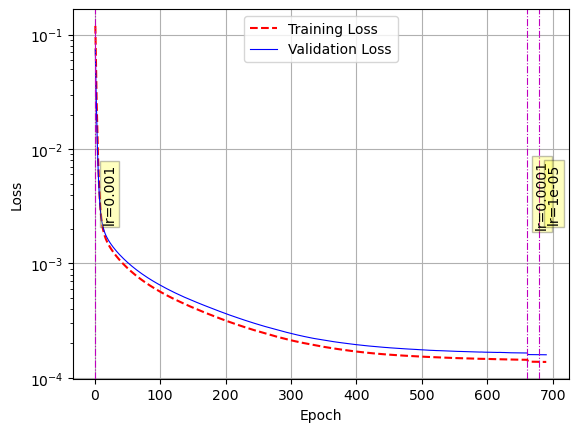

In [41]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 52


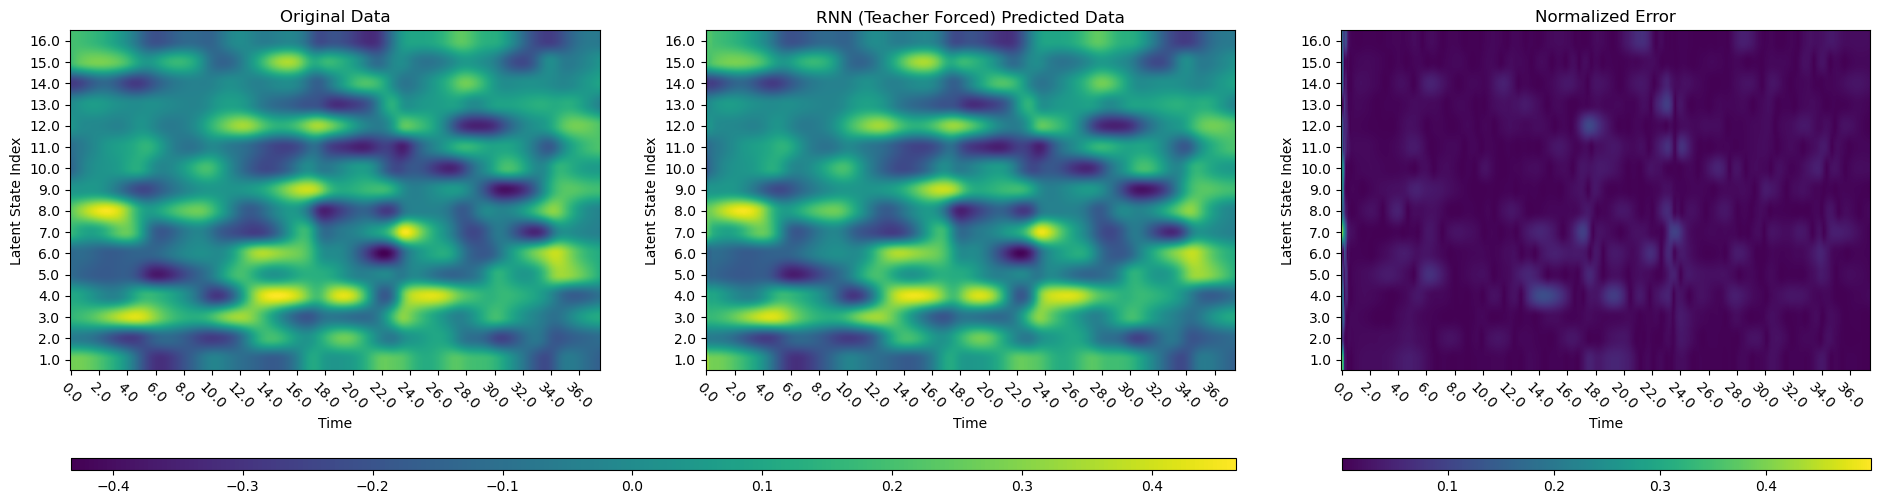

In [42]:
# data_type = 'training'
rnn_net.reset_states()
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [43]:
prediction.shape, data_out.shape

((32, 375, 16), (375, 16))

In [44]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = data.copy()
    shape = new_data.shape
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 26


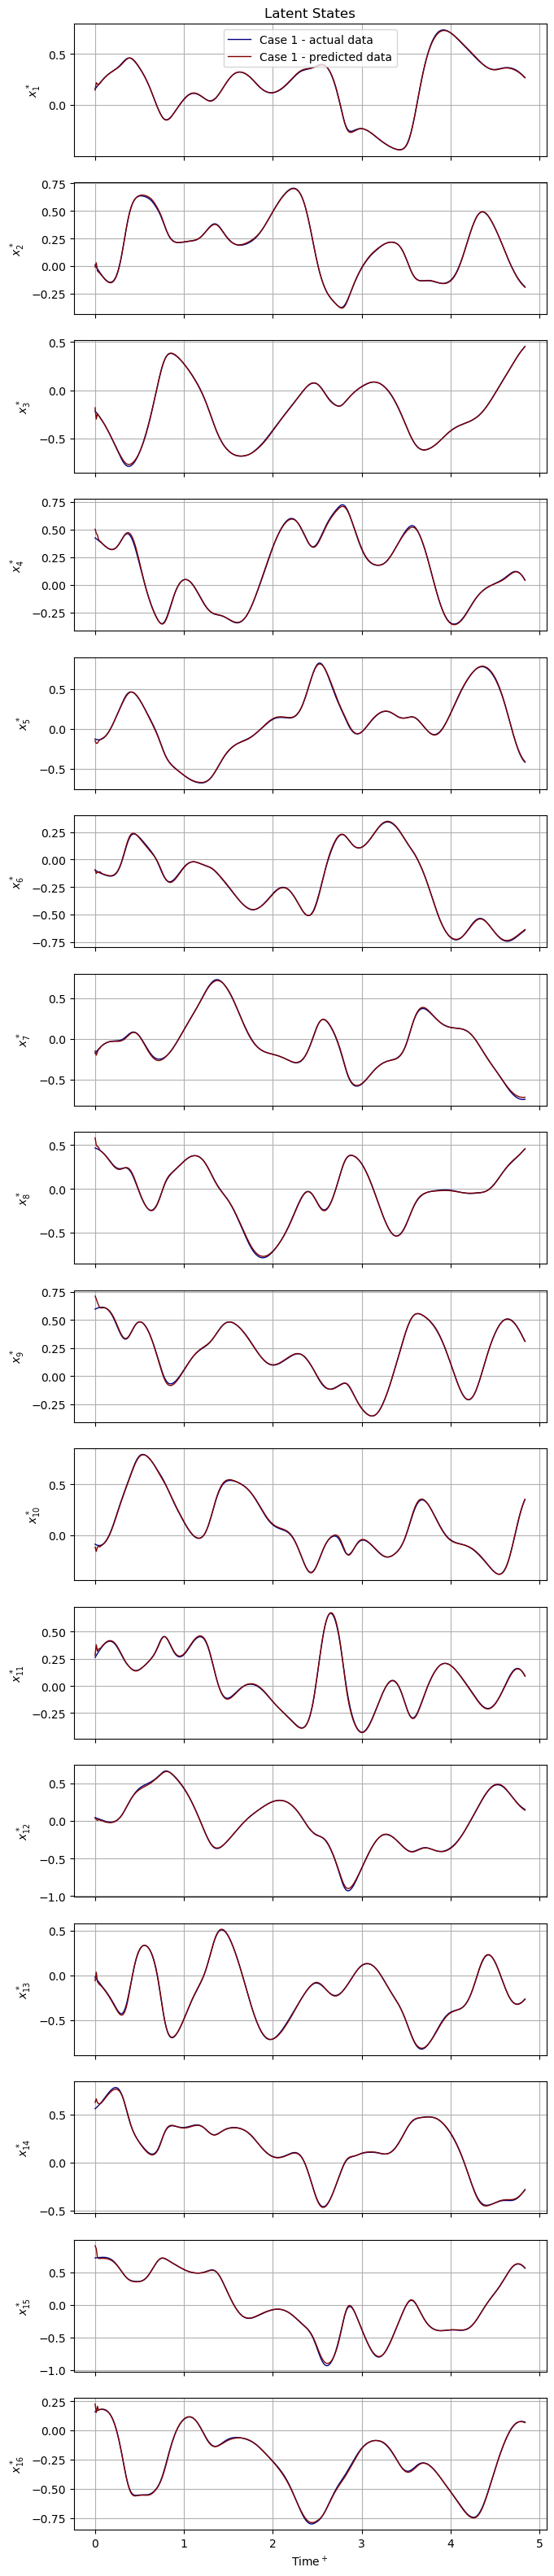


4.8363212491718865


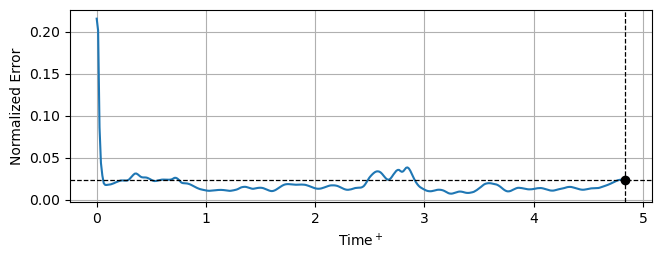

In [45]:
if rnn_net.stateful == True:
    for rnn_layer in rnn_net.ESN_layers:
        rnn_layer.reset_states()


data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
# data_out = invert_normalization(data_out, normalization_arr)

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# prediction = rnn_net(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = invert_normalization(prediction, normalization_arr)

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

plt.show()

# Auto Regressive ESN

In [46]:
s_in = testing_data_rnn_input.shape
s_out = testing_data_rnn_output.shape

if stateful == True:
    testing_data_rolling_count = 0
    for i in range(len(rnn_data_boundary_idx_arr)):
        # idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
        num_samples = num_samples_arr[i]
        num_train = num_train_arr[i]
        num_val = num_val_arr[i]
        num_test = num_test_arr[i]

        nbatches_test = num_test // batch_size
        
        temp = testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test].copy()
        for j in range(batch_size):
            testing_data_rnn_input[testing_data_rolling_count+j*nbatches_test:testing_data_rolling_count+(j+1)*nbatches_test] = temp[j*nbatches_test:(j+1)*nbatches_test]
        del(temp)
        
        temp = testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test].copy()
        for j in range(batch_size):
            testing_data_rnn_output[testing_data_rolling_count+j*nbatches_test:testing_data_rolling_count+(j+1)*nbatches_test] = temp[j*nbatches_test:(j+1)*nbatches_test]
        del(temp)
        testing_data_rolling_count += num_test

testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])

In [47]:
T_sample_input_AR = 1*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 5*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx : 0
data_idx : 2454
data_.shape : (1, 464, 16)


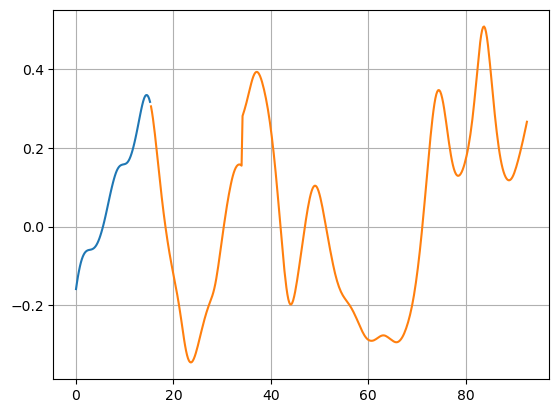

In [48]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(dt_rnn*np.arange(num_sample_input_AR), data_[0, 0:num_sample_input_AR, 0])
plt.plot(dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR), data_[0, num_sample_input_AR:, 0])
plt.grid(True)
plt.show()

In [54]:
prediction_lst = []

for layer in rnn_net.ESN_layers:
    layer.reset_states()

ar_rnn_input = np.tile(data_[:, 0:num_sample_input_AR, :], [batch_size, 1, 1])
input_preds = np.array(rnn_net(ar_rnn_input, training=False))

prediction_lst.append(input_preds[:, -1])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array([[prediction_lst[-1]]])
    output = np.array(rnn_net(data_in_i, training=False))[0, 0]
    prediction_lst.append(output)

IndexError: Exception encountered when calling layer "esn" (type ESN).

list index out of range

Call arguments received:
  • inputs=tf.Tensor(shape=(16,), dtype=float32)
  • training=False
  • manual_training=False

In [ ]:
prediction_lst = np.stack(prediction_lst)

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

In [ ]:
lyap_time = np.mean(lyapunov_time_arr)

n = 1
num_latent_states = input_preds.shape[-1]
N = num_sample_output_AR#num_output_timesteps

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, data_[0, 0:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, data_[0, num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst[:, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (data_[0, num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[:, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if len(predhor_idx.shape) == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

In [55]:
if use_weights_post_dense == True:
    print(rnn_net.postWout.individual_weights)

<tf.Variable 'esn/time_distributed_1/individual_weights:0' shape=(16,) dtype=float32, numpy=
array([1.669134 , 1.696849 , 1.579366 , 1.6772498, 1.8483608, 1.8114957,
       1.8953109, 1.7440948, 1.6976094, 1.8309338, 1.8672774, 1.876665 ,
       1.7492021, 1.8272595, 1.8345888, 1.9196799], dtype=float32)>
